In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gefera as gf

from scipy.optimize import minimize

In [2]:
# load Kepler data for the double transit
t, y = np.loadtxt('k51.txt').T
# arrays need to be fortran-contiguous, a 
# characteristic which isn't preserved when 
# we transpose the numpy array
t = np.ascontiguousarray(t)
y = np.ascontiguousarray(y)

In [3]:
# initial guess for parameters of Kepler-51 d
a1 = 124.7 
t1 = 16.56
e1 = 0.00001
p1 = 130.194
w1 = 90.0 * np.pi / 180
b1 = 0.05
i1 = np.arccos(b1 / a1)
a1 = a1 * ac.R_sun.value / ac.au.value
r1 = 0.1

# initial guess for parameters of Kepler-51 b
a2 = 61.5 
t2 = 12.41
e2 = 0.00001
p2 = 45.154
w2 = 0.1 * np.pi / 180
om2 = 160 * np.pi / 180
b2 = 0.0
i2 = np.arccos(b2 / a2)
a2 = a2 * ac.R_sun.value / ac.au.value
r2 = 0.07

# initial guess for quadratic limb-darkening parameters
u1 = 0.6
u2 = 0.2

# build the system 
o1 = gf.PrimaryOrbit(a1, t1, e1, p1, w1, i1)
o2 = gf.ConfocalOrbit(a2, t2, e2, p2, om2, w2, i2)
sys = gf.ConfocalSystem(o1, o2)

# returns the likelihood and the jacobian of the likelihood
def fun_jac(args):
    sigma, a1, t1, e1, p1, w1, i1, a2, t2, e2, p2, om2, w2, i2, r1, r2, u1, u2 = args
    o1 = gf.PrimaryOrbit(a1, t1, e1, p1, w1, i1)
    o2 = gf.ConfocalOrbit(a2, t2, e2, p2, om2, w2, i2)
    sys = gf.ConfocalSystem(o1, o2)
    ll, dll = sys.loglike(y - 1, t, u1, u2, r1, r2, sigma, grad=True)
    return -ll, -dll

# get the initial light curve for comparison later
x0 = [0.0016, a1, t1, e1, p1, w1, i1, a2, t2, e2, p2, om2, w2, i2, r1, r2, u1, u2]
o1 = gf.PrimaryOrbit(a1, t1, e1, p1, w1, i1)
o2 = gf.ConfocalOrbit(a2, t2, e2, p2, om2, w2, i2)
sys = gf.ConfocalSystem(o1, o2)
lc_start = sys.lightcurve(t, u1, u2, r1, r2, grad=False)

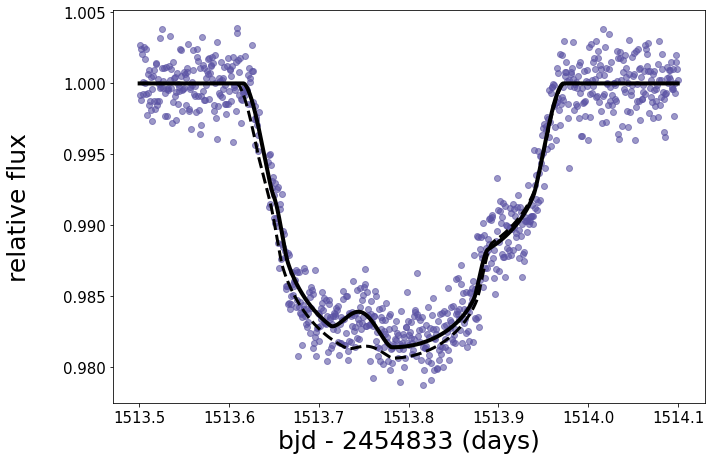

In [4]:
# do the minimization
# I've found that the truncated newtonian (TNC) method works well with the gradient 
# but if you're not using gradients then BFGS seems to work better in most cases
res = minimize(fun_jac, x0, jac=True, method='TNC')

# get the minimized lightcurve
sigma, a1, t1, e1, p1, w1, i1, a2, t2, e2, p2, om2, w2, i2, r1, r2, u1, u2 = res.x
o1 = gf.PrimaryOrbit(a1, t1, e1, p1, w1, i1)
o2 = gf.ConfocalOrbit(a2, t2, e2, p2, om2, w2, i2)
sys = gf.ConfocalSystem(o1, o2)
lc = sys.lightcurve(t, u1, u2, r1, r2, grad=False)

# plot everything 
plt.figure(figsize=(10, 7))
plt.plot(t, y, 'o', color=plt.cm.Spectral(0.99), alpha=0.6)
plt.plot(t, lc + 1, color='k', linewidth=4)
plt.plot(t, lc_start + 1, '--', color='k', linewidth=3)

plt.ylabel('relative flux\n', fontsize=25)
plt.xlabel('bjd - 2454833 (days)', fontsize=25)
plt.xticks(fontsize=15);
plt.yticks(fontsize=15);
plt.tight_layout()
plt.subplots_adjust(top=0.9)